In [1]:
import numpy as np
import os, sys
import time
import pandas as pd
import matplotlib.pyplot as plt
# Add the parent directory (one level up) to the Python path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.insert(0, parent_dir)

import pipeline
from modules.content_based import ContentBasedFiltering
from modules.rule_based import RuleBasedFiltering
from modules.collaborative_filtering import CollaborativeFiltering
from surprise import Dataset, SVD

import warnings
from sklearn.metrics import mean_squared_error
# Suppress RuntimeWarnings for empty slices
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Mean of empty slice")


In [2]:
#load the dataset
pline = pipeline.Pipeline()
cols = ['user', 'item', 'rating', 'timestamp']
df = pline.load_dataset('../storage/u.data', column_names = cols)

#show ratings dataset
df.head(10)

#temporal data partitioning
train_data_temp, test_data_temp = pline.partition_data(df, partition_type = 'temporal')

#save data to use in the functions
train_data_temp.to_csv('../storage/u.data_train_temp', sep='\t', header=False,index=False)
test_data_temp.to_csv('../storage/u.data_test_temp', sep='\t', header=False,index=False)

In [6]:
#nCGD function
def nCGD(predicted_ratings, true_ratings):

    ranked_indices = np.argsort(predicted_ratings)[::-1]

    # Function to calculate DCG
    def dcg(relevance_scores):
        return np.sum(relevance_scores / np.log2(np.arange(2, len(relevance_scores) + 2)))

    dcg_value = dcg(true_ratings[ranked_indices])

    ideal_ranking = np.argsort(true_ratings)[::-1]
    idcg_value = dcg(true_ratings[ideal_ranking])
    nCGD = dcg_value / idcg_value

    return nCGD

### Rule Based Filtering ###

Temporal test set results using rule based filtering.

In [3]:
#load model
recommender = RuleBasedFiltering(
    ratings_file='../storage/u.data_train_temp',
    metadata_file='../storage/u.item'
)

In [4]:
#rule based filtering 
trs = []
prs = []

for _, row in test_data_temp.iterrows():
    user_id, item_id, true_rating = row['user'], row['item'], row['rating']
    try:
        predicted_rating = recommender._predict(item_id)
        trs.append(true_rating)
        prs.append(predicted_rating)
    except ValueError:
        continue

In [10]:
#data dict
RMSE_Data = {}
RMSE_Data['rule based'] = np.sqrt(mean_squared_error(trs, prs))

nCGD_Data = {}
nCGD_Data['rule based'] = nCGD(np.array(prs), np.array(trs))

### Content Based Filtering ###

In [11]:
cb_recommender = ContentBasedFiltering(
        ratings_file='../storage/u.data_train_temp',
        metadata_file='../storage/u.item'
    )

In [12]:
#evaluate
trs = []
prs = []

for _, row in test_data_temp.iterrows():
    user_id, item_id, true_rating = row['user'], row['item'], row['rating']
    try:
        predicted_rating = 5 * cb_recommender.predict(user_id, item_id)
        trs.append(true_rating)
        prs.append(predicted_rating)
    except:
        pass

In [13]:
RMSE_Data['content based'] = np.sqrt(mean_squared_error(trs, prs))
nCGD_Data['content based'] = nCGD(np.array(prs), np.array(trs))

### Collaborative Filtering ###

In [14]:
svd_params = {'n_factors': 200, 'n_epochs': 100, 'lr_all': 0.01, 'reg_all': 0.1}
recommender = CollaborativeFiltering(
    ratings_file='../storage/u.data_train_temp',
    metadata_file='../storage/u.item',
    algorithm=SVD(**svd_params)
)

# Fit the model
recommender.fit()

In [15]:
#evaluate using the test set
trs = []
prs = []

for _, row in test_data_temp.iterrows():
    user_id, item_id, true_rating = row['user'], row['item'], row['rating']
    try:
        predicted_rating = recommender.predict(user_id, item_id)
        trs.append(true_rating)
        prs.append(predicted_rating)
    except:
        pass

In [16]:
RMSE_Data['collaborative filtering'] = np.sqrt(mean_squared_error(trs, prs))
nCGD_Data['collaborative filtering'] = nCGD(np.array(prs), np.array(trs))

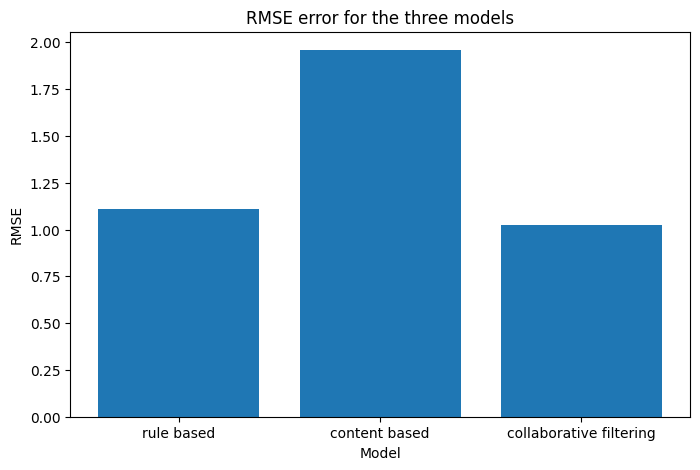

In [17]:
plt.figure(figsize = (8, 5))
plt.bar(RMSE_Data.keys(), RMSE_Data.values())
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('RMSE error for the three models')
plt.show()

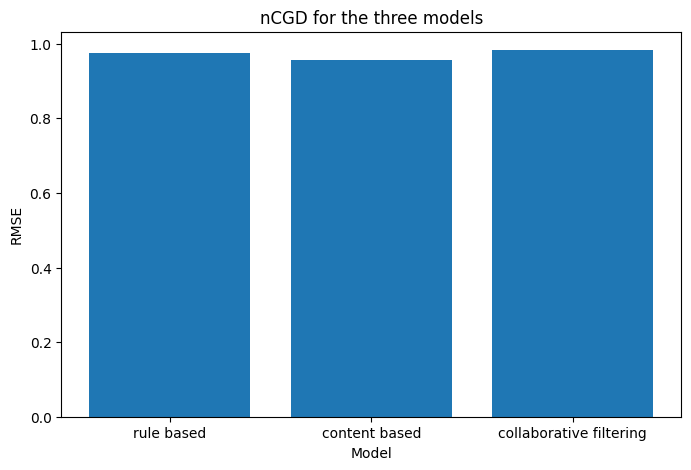

In [19]:
plt.figure(figsize = (8, 5))
plt.bar(nCGD_Data.keys(), nCGD_Data.values())
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.title('nCGD for the three models')
plt.show()

The first chart compares the Root Mean Square Error (RMSE) of three recommendation models: rule-based, content-based, and collaborative filtering. Among these, the rule-based model shows moderate performance with a relatively low RMSE. This suggests that the simple rules it employs, such as averaging ratings by genre or overall popularity, can offer decent predictive accuracy. Its reliance on straightforward logic makes it robust in situations where user-specific interaction data is limited, but it may lack the ability to capture nuanced preferences.

The content-based model performs the weakest, with the highest RMSE among the three. This indicates significant challenges in accurately predicting user ratings. Content-based filtering often relies heavily on item metadata (e.g., genres, features) and assumes that users will prefer items similar to those they previously interacted with. While this can work for users with rich interaction histories, the lack of personalization and generalization ability for sparse data leads to overfitting or inaccurate predictions, particularly for diverse user tastes.

Collaborative filtering outperforms the other methods, with the lowest RMSE. Its strength lies in leveraging patterns in user-item interactions, capturing shared behaviors and preferences effectively, especially when sufficient data is available. This model excels because it incorporates community-level preferences, which allow it to generalize well to unseen items or users with similar habits. Based on these results, collaborative filtering should be the primary recommendation method. However, to further improve accuracy and address weaknesses in content-based and rule-based approaches, a hybrid system combining metadata and user interactions can provide a balanced and effective solution.

The nCGD calculation also shows the highest value for "collaborative filtering". SO this method would be ideal to use as the model for our recommendation system. 